In [166]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')
from collections import Counter, defaultdict

In [167]:
data = pd.read_csv('./data/after_clean.csv', encoding='gb18030')

In [168]:
customer_freq = data.groupby('AlipayAccount').agg({'OrderID':'count'}).sort_values('OrderID', ascending = False)
customer_freq.shape

(117687, 1)

In [169]:
data.shape

(143939, 30)

We have 143939 records, 117687 customers.  

In [170]:
data.head(2)

,OrderID,MemberName,AlipayAccount,OwnedAmount,DeliveryFee,PointsPay,Total,PointsEarned,DirectPay,PointsPay.1,OrderStatus,BuyerMessage,ReceiverName,ReceivingAdd,DeliverMethod,CellPhone,OrderTime,PaytTime,ItemName,ItemCate,DeliverCompany,OrderNote,OrderItemNo,DeliveredTime,StoreReceived,CunTaoOrder,Province,City,OrderToPay(s),PayToReceive(h)
0,"=""561099105503109255""",雷霆3战机,342239175@qq.com,154.84,0.0,0.0,154.84,77.0,154.84,0.0,交易成功,No,陈丹,福建省 福州市 仓山区 东升街道东园路10号金辉莱茵城14号楼（东辉社区）(000000),快递,'13405907147,2019-07-31 23:28:46,2019-07-31 23:28:58,迪宝乐电子积木儿童益智拼装电路玩具男女孩物理教科书5-6-12岁,1.0,韵达快递,No,1.0,2019-08-09 22:38:05,154.84元,否,福建省,福州市,12.0,215.0
1,"=""561103267468252376""",konglingsheng888,kls666@sina.com,109.00,0.0,0.0,109.00,54.0,109.00,0.0,交易成功,No,孔令晟,安徽省 铜陵市 铜官山区 铜官山区虚镇秀水山庄4栋401(244000),快递,'13856271285,2019-07-31 22:58:03,2019-07-31 22:58:30,迪士尼书包小学生男1-3-4年级汽车麦昆卡通儿童护脊双肩背包,1.0,圆通速递,No,1.0,2019-08-03 19:47:38,109.00元,否,安徽省,铜陵市,27.0,68.0


In [171]:
data['StoreReceived'] = data['StoreReceived'].apply(lambda x:float(x[:-1]))

In [172]:
data['OrderTime'] = data['OrderTime'].apply(lambda x:pd.to_datetime(x))
data['PaytTime'] = data['PaytTime'].apply(lambda x:pd.to_datetime(x))

In [173]:
data['DaysToAug'] = data['OrderTime'].apply(lambda x:\
            int(str(pd.to_datetime('2019-08-01 00:00:00') - x).split(' ')[0]) + 1)

In [174]:
customer_freq.head(10)

,OrderID
AlipayAccount,
13143505932,61
996038333@qq.com,49
financetba-th@lazada.com,40
17712515083,40
995252337@qq.com,26
13488112766,20
williamk01@qq.com,18
kaensmile@sohu.com,17
financetba-id@lazada.com,17


In [175]:
def interval_two_orders(df, accounts):
    '''
    Calculate and plot the distribution of interval between two orders of one customer
    df: the dataframe contains records of all orders
    accounts: list of customer accounts 
    '''
    for account in accounts:
        tmp = df[df['AlipayAccount'] == account][['AlipayAccount','DaysToAug']]
        interval = np.array(tmp.DaysToAug)[1:] - np.array(tmp.DaysToAug)[:-1]
        
        interval_days = Counter(interval)
        interval_days_df = pd.DataFrame({'interval_days':list(interval_days.keys()),\
                                         'count':list(interval_days.values())}).sort_values('interval_days').\
                                          set_index('interval_days')
                                         
        interval_days_df.plot(kind = 'bar', rot=0)
        plt.yticks(np.arange(0, max(interval_days_df['count']+1), step=1))
        plt.title(f'interval between two orders of {account}')

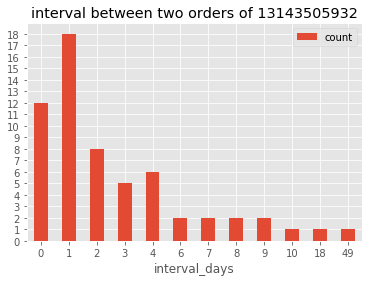

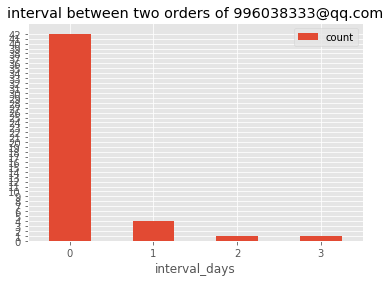

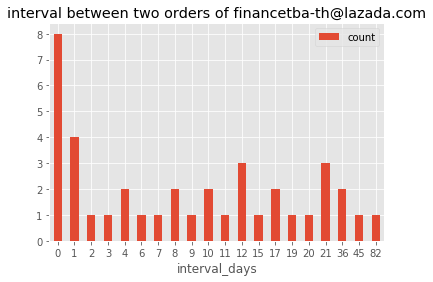

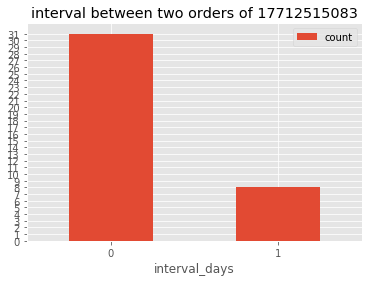

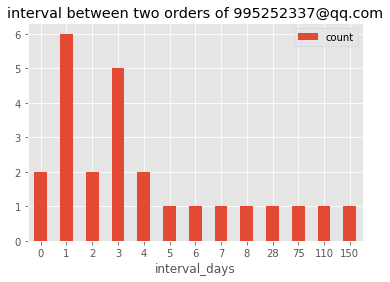

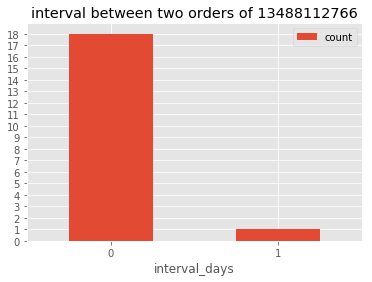

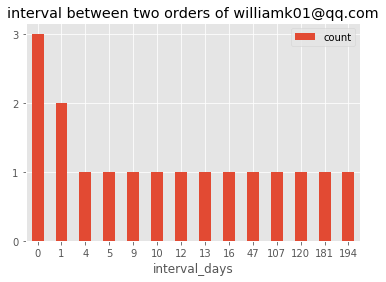

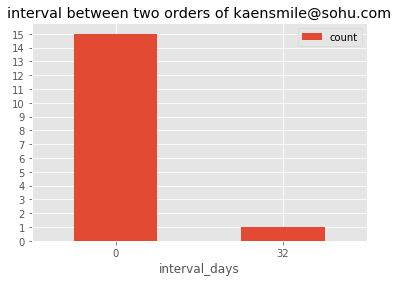

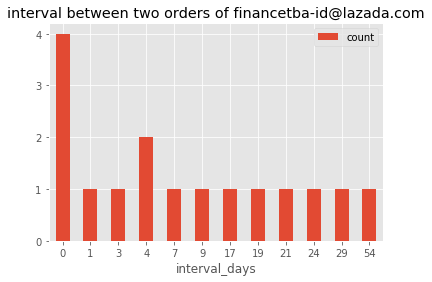

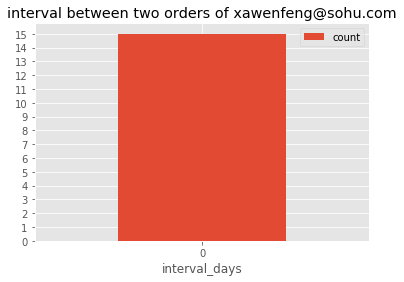

In [176]:
# 购买次数最多的10个用户的intervals
interval_two_orders(data, list(customer_freq.head(10).index))

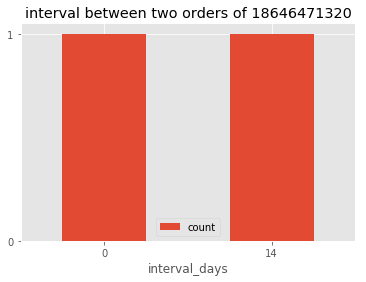

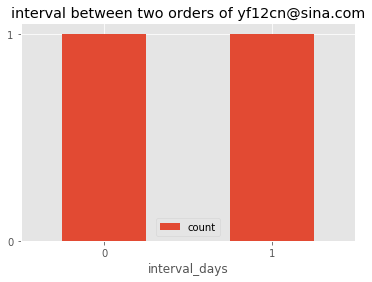

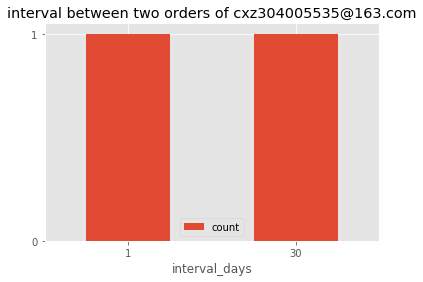

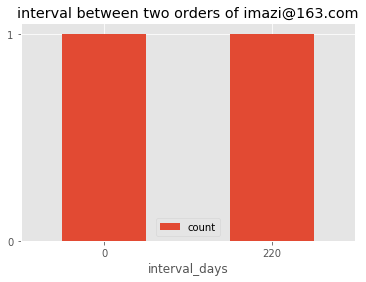

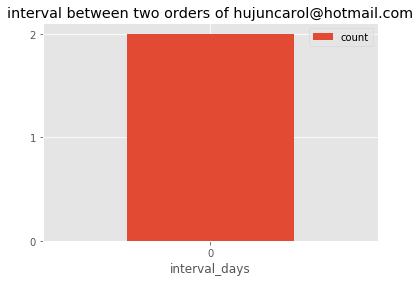

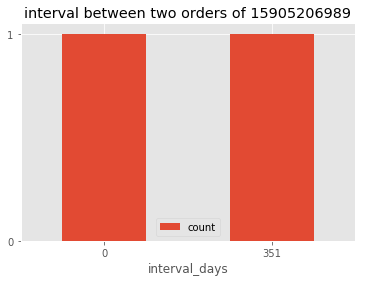

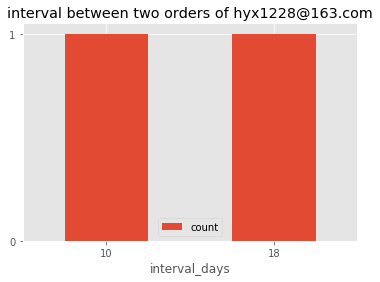

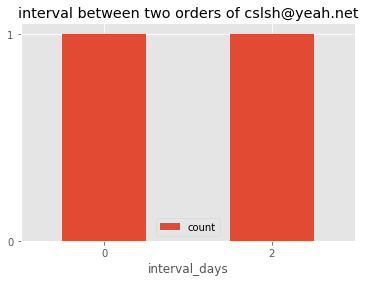

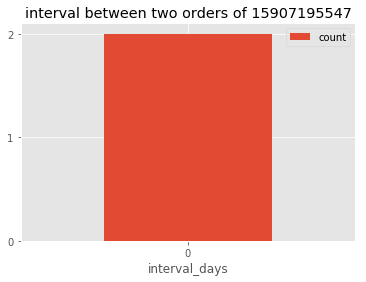

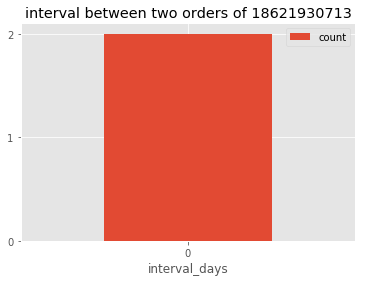

In [178]:
# 购买次数为3的10个用户的intervals
interval_two_orders(data, list(customer_freq[customer_freq['OrderID'] == 3].head(10).index))

In [177]:
# 所有次数大于1的用户的intervals
accounts_2 = list(customer_freq[customer_freq['OrderID'] > 1].index)

In [179]:
test = []
for account in accounts_2:
    tmp = data[data['AlipayAccount'] == account][['AlipayAccount','DaysToAug']]
    interval = np.array(tmp.DaysToAug)[1:] - np.array(tmp.DaysToAug)[:-1]
    test.append(list(interval))
    
test = sum(test,[])

In [180]:
interval_days = Counter(test)
interval_days_df = pd.DataFrame({'interval_days':list(interval_days.keys()),\
                                 'count':list(interval_days.values())}).sort_values('interval_days').\
                                  set_index('interval_days')

In [181]:
interval_days_df.reset_index(inplace=True)

Text(0.5,1,'How long will customers come back?')

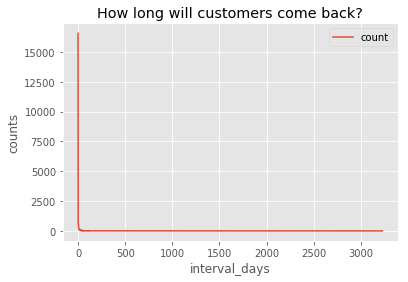

In [412]:
interval_days_df.plot('interval_days', 'count')
plt.ylabel('counts')
plt.title('How long will customers come back?')

Text(0.5,1,'How long will customers come back?')

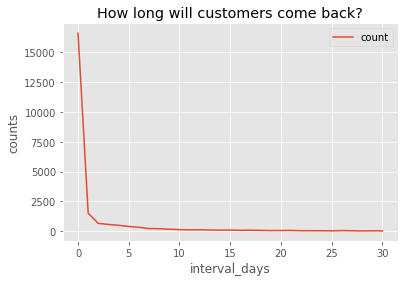

In [413]:
interval_days_df[interval_days_df['interval_days'] < 31].plot('interval_days', 'count')
plt.ylabel('counts')
plt.title('How long will customers come back?')

In [20]:
# Most customers will come back in 30 days.
# 目标是预测一个用户进行购买行为T天后，还会继续购买的概率
# or   预测一个用户进行购买行为T天内，还会继续购买的概率？

In [184]:
def draw_correlation(df, col1, col2):
    df.plot(col1, col2, kind='scatter')
    cor = np.corrcoef(df[col1], df[col2])[0,1]
    print(f'The correlation between {col1} and {col2} is {cor}.')

The correlation between OwnedAmount and Total is 0.9999987195132183.


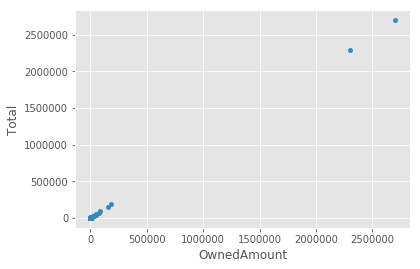

In [185]:
draw_correlation(data, 'OwnedAmount', 'Total')

'OrderID'        : drop  
'MemberName'     : drop  
'AlipayAccount'  : drop
'OwnedAmount'    : highly correlated with Total, DirectPay, 2 outliers, drop(?
'DeliveryFee'    : keep
'PointsPay'      : keep
'Total'          : drop
'PointsEarned'   : keep
'DirectPay'      : drop
'PointsPay.1'    : drop, high correlated with PointsPay
'OrderStatus'    : 1/0
'BuyerMessage'   : drop
'ReceiverName'   : drop
'ReceivingAdd'   : drop
'DeliverMethod'  : dummy
'CellPhone'      : drop
'OrderTime'      : drop
'PaytTime'       : drop
'ItemName'       : drop
'ItemCate'       : drop(??
'DeliverCompany' : drop
'OrderNote'      : drop 这是卖家的备注
'OrderItemNo'    : drop, high correlated with OwnedAmount(????
'DeliveredTime'  : drop
'StoreReceived'  : drop
'CunTaoOrder'    : 1/0
'Province'       : dummy
'City'           : drop
'OrderToPay(s)'  : 暂时drop
'PayToReceive(h)': 暂时drop
'DaysToAug'      : drop

添加列:
    某用户在本次购买之前的购买次数

In [186]:
OrderCount = []
for i in range(data.shape[0]):
    account = data.iloc[i,]['AlipayAccount']
    date = data.iloc[i,]['OrderTime']
    count = data[(data['AlipayAccount'] == account) & (data['OrderTime'] < date)].shape[0]
    OrderCount.append(count)
    
    if i%1000 == 0:
        print(i)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000


In [187]:
data['OrderCount'] = OrderCount

In [188]:
data['OrderStatus1'] = data['OrderStatus'].apply(lambda x:1 if x == '交易成功' else 0)

In [189]:
data1 = data[data['OrderTime'] < '2019-07-01 00:00:00']

In [190]:
data1.shape

(143163, 33)

In [191]:
ordered_in_30days = []

for i in range(data1.shape[0]):
    orderid = data1.iloc[i,]['OrderID']
    account = data1.iloc[i,]['AlipayAccount']
    date_low = data1.iloc[i,]['OrderTime'] 
    date_up = date_low + pd.DateOffset(30)
    
    data_except = data[data['OrderID'] != orderid]
    orders_in_30days = data_except[(data_except['AlipayAccount']==account) &\
                                   ((data_except['OrderTime']>=date_low)&(data_except['OrderTime']<=date_up))]
    ordered_in_30days.append(orders_in_30days.shape[0])
    
    if i%100 == 0:
        print(i)
    

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

133000
133100
133200
133300
133400
133500
133600
133700
133800
133900
134000
134100
134200
134300
134400
134500
134600
134700
134800
134900
135000
135100
135200
135300
135400
135500
135600
135700
135800
135900
136000
136100
136200
136300
136400
136500
136600
136700
136800
136900
137000
137100
137200
137300
137400
137500
137600
137700
137800
137900
138000
138100
138200
138300
138400
138500
138600
138700
138800
138900
139000
139100
139200
139300
139400
139500
139600
139700
139800
139900
140000
140100
140200
140300
140400
140500
140600
140700
140800
140900
141000
141100
141200
141300
141400
141500
141600
141700
141800
141900
142000
142100
142200
142300
142400
142500
142600
142700
142800
142900
143000
143100


In [192]:
data1['OrderIn30'] = ordered_in_30days

In [193]:
data1['OrderIn30'] = data1['OrderIn30'].apply(lambda x:1 if x > 0 else 0)

In [194]:
data1['CunTaoOrder'] = data1['CunTaoOrder'].apply(lambda x:0 if x == '否' else 1)

In [81]:
data1 = data1.drop(['OrderID', 'MemberName', 'AlipayAccount', 'Total', 'DirectPay', 'PointsPay.1', 'OrderStatus',\
                  'BuyerMessage', 'ReceiverName', 'ReceivingAdd', 'CellPhone', 'OrderTime', 'PaytTime',\
                  'ItemName', 'ItemCate', 'DeliverCompany', 'OrderNote', 'OrderItemNo', 'DeliveredTime',\
                  'StoreReceived', 'City', 'OrderToPay(s)', 'PayToReceive(h)', 'DaysToAug'], axis =1)

data1.reset_index(drop=True, inplace=True)

In [85]:
data1.head()

,OwnedAmount,DeliveryFee,PointsPay,PointsEarned,DeliverMethod,CunTaoOrder,Province,OrderCount,OrderStatus1,OrderIn30
0,183.00,0.0,0.0,91.0,快递,1,浙江省,0,1,0
1,188.00,0.0,0.0,94.0,快递,0,江苏省,0,1,0
2,149.94,0.0,0.0,74.0,快递,0,辽宁省,0,1,0
3,98.00,0.0,0.0,0.0,快递,0,四川省,0,0,0
4,123.00,0.0,0.0,61.0,快递,0,广西壮族自治区,0,1,0


In [88]:
data_final = pd.get_dummies(data1, drop_first=True)

In [91]:
data_final.shape

(138995, 49)

In [89]:
data_final.head()

,OwnedAmount,DeliveryFee,PointsPay,PointsEarned,CunTaoOrder,OrderCount,OrderStatus1,OrderIn30,DeliverMethod_卖家承担运费,DeliverMethod_平邮,DeliverMethod_快递,DeliverMethod_虚拟物品,Province_云南省,Province_云浮市,Province_内蒙古自治区,Province_北京,Province_台湾,Province_台湾省,Province_吉林省,Province_吉隆坡,Province_四川省,Province_天津,Province_宁夏回族自治区,Province_安徽省,Province_山东省,Province_山西省,Province_广东省,Province_广西壮族自治区,Province_新疆维吾尔自治区,Province_江苏省,Province_江西省,Province_河北省,Province_河南省,Province_浙江省,Province_海南省,Province_海外,Province_湖北省,Province_湖南省,Province_澳门特别行政区,Province_甘肃省,Province_福建省,Province_西藏自治区,Province_贵州省,Province_辽宁省,Province_重庆,Province_陕西省,Province_青海省,Province_香港特别行政区,Province_黑龙江省
0,183.00,0.0,0.0,91.0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,188.00,0.0,0.0,94.0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,149.94,0.0,0.0,74.0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,98.00,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,123.00,0.0,0.0,61.0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [424]:
data_final.to_csv('./data/data_final.csv', encoding='gb18030')

# Logistic Regression

In [426]:
X = data_final.drop('OrderIn30', axis=1)

In [427]:
y = data_final['OrderIn30']

In [428]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [429]:
X_train.head()

,OwnedAmount,DeliveryFee,PointsPay,PointsEarned,CunTaoOrder,OrderCount,OrderStatus1,DeliverMethod_卖家承担运费,DeliverMethod_平邮,DeliverMethod_快递,DeliverMethod_虚拟物品,Province_云南省,Province_云浮市,Province_内蒙古自治区,Province_北京,Province_台湾,Province_台湾省,Province_吉林省,Province_吉隆坡,Province_四川省,Province_天津,Province_宁夏回族自治区,Province_安徽省,Province_山东省,Province_山西省,Province_广东省,Province_广西壮族自治区,Province_新疆维吾尔自治区,Province_江苏省,Province_江西省,Province_河北省,Province_河南省,Province_浙江省,Province_海南省,Province_海外,Province_湖北省,Province_湖南省,Province_澳门特别行政区,Province_甘肃省,Province_福建省,Province_西藏自治区,Province_贵州省,Province_辽宁省,Province_重庆,Province_陕西省,Province_青海省,Province_香港特别行政区,Province_黑龙江省
137933,169.0,0.0,0.0,84.0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
55564,288.0,0.0,0.0,144.0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
124578,158.0,30.0,0.0,79.0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
66135,188.0,0.0,0.0,94.0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6444,149.0,0.0,0.0,74.0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [430]:
from sklearn.preprocessing import StandardScaler

standard_features = ['OwnedAmount', 'DeliveryFee', 'PointsPay', 'PointsEarned']
std = StandardScaler()
scaler = std.fit(X_train.loc[:,standard_features])
X_train.loc[:,standard_features] = scaler.transform(X_train.loc[:,standard_features])
X_test.loc[:,standard_features] = scaler.transform(X_test.loc[:,standard_features])

In [431]:
X_train.head()

,OwnedAmount,DeliveryFee,PointsPay,PointsEarned,CunTaoOrder,OrderCount,OrderStatus1,DeliverMethod_卖家承担运费,DeliverMethod_平邮,DeliverMethod_快递,DeliverMethod_虚拟物品,Province_云南省,Province_云浮市,Province_内蒙古自治区,Province_北京,Province_台湾,Province_台湾省,Province_吉林省,Province_吉隆坡,Province_四川省,Province_天津,Province_宁夏回族自治区,Province_安徽省,Province_山东省,Province_山西省,Province_广东省,Province_广西壮族自治区,Province_新疆维吾尔自治区,Province_江苏省,Province_江西省,Province_河北省,Province_河南省,Province_浙江省,Province_海南省,Province_海外,Province_湖北省,Province_湖南省,Province_澳门特别行政区,Province_甘肃省,Province_福建省,Province_西藏自治区,Province_贵州省,Province_辽宁省,Province_重庆,Province_陕西省,Province_青海省,Province_香港特别行政区,Province_黑龙江省
137933,-0.006821,-0.161176,-0.101177,0.122450,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
55564,0.003625,-0.161176,-0.101177,0.772146,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
124578,-0.007786,1.793762,-0.101177,0.068309,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
66135,-0.005153,-0.161176,-0.101177,0.230733,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6444,-0.008576,-0.161176,-0.101177,0.014168,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [310]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression


grid = {"C":np.logspace(-3,3,7), 
        "penalty":["l1","l2"]
       }

logit = LogisticRegression()
logit_cv=GridSearchCV(logit, grid, cv=10)
logit_cv.fit(X_train,y_train)

print("tuned hpyerparameters :(best parameters) ",logit_cv.best_params_)
print("accuracy :",logit_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.01, 'penalty': 'l1'}
accuracy : 0.8535294359480349


In [432]:
logit_best = LogisticRegression(penalty='l1', C=0.01)
logit_best.fit(X_train,y_train) 

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [433]:
y_pred = logit_best.predict(X_train)

In [434]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train, y_pred)

array([[78731,  2930],
       [11318,  4317]])

In [435]:
tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()
print(f'True Positive: {tp}\nTrue Negative: {tn}\nFalse Positive: {fp}\nFalse Negative: {fn}')

True Positive: 4317
True Negative: 78731
False Positive: 2930
False Negative: 11318


In [436]:
tp/(tp + fn)

0.27611128877518387

In [ ]:
15635 : 81661
其实买了 但是预测为没买的很多
意味着失去了很多潜在客户（流失率增加）

除了考虑用户是否流失外，还应当考虑该用户的流失概率.流失概率越大的优先对其采取优惠措施

In [438]:
y_test_pred = logit_best.predict(X_test)

In [439]:
confusion_matrix(y_test, y_test_pred)

array([[33723,  1290],
       [ 4804,  1882]])

## Set cutoff

In [228]:
y_pred_proba = logit_best.predict_proba(X_train)

In [229]:
y_pred_proba

array([[0.92461346, 0.07538654],
       [0.94397323, 0.05602677],
       [0.94382575, 0.05617425],
       ...,
       [0.44598455, 0.55401545],
       [0.92452082, 0.07547918],
       [0.94415876, 0.05584124]])

In [247]:
from sklearn import metrics

recall_ls = []
accuracy_ls = []
f1_ls = []
thresholds = np.arange(0,1,0.001)

for thres in thresholds:
    y_pred = np.where(y_pred_proba[:,0]<thres,1,0)
    tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()
    recall = tp/(tp + fn)
    acc = (tp + tn)/(tp+tn+fp+fn)
    precision = tp/(tp + fp)
    f1 = 2*precision*recall/(precision+recall)
    
    
    recall_ls.append(recall)
    accuracy_ls.append(acc)
    f1_ls.append(f1)
    
#     print(f'threshold is {thres}')
#     print(confusion_matrix(y_train, y_pred))
#     print(f'recall is {recall}')
#     print(f'accuracy is {acc}')
#     print('-'*50)

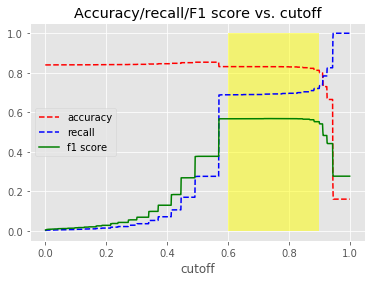

In [300]:
plt.plot(thresholds, accuracy_ls,'r--', label='accuracy')
plt.plot(thresholds, recall_ls, 'b--', label='recall')
plt.plot(thresholds, f1_ls, 'g',label='f1 score')

plt.plot(thresholds, np.array([1]*1000), color='white', alpha=0)
plt.fill_between(thresholds, np.array([1]*1000), where=(thresholds >0.6)&(thresholds<0.9), facecolor='yellow', alpha=0.5)

plt.xlabel('cutoff')
plt.title('Accuracy/recall/F1 score vs. cutoff')
plt.legend(loc=0)
plt.show()

In [362]:
print('Recall is 0.6952350495682763.\nAccuracy is 0.8284513237954284.')

Recall is 0.6952350495682763.
Accuracy is 0.8284513237954284.


In [443]:
y_pred_proba = logit_best.predict_proba(X_test)
y_pred_cutoff = np.where(y_pred_proba[:,0]<0.8,1,0)
confusion_matrix(y_test, y_pred_cutoff)

## Up-sampling

In [445]:
from sklearn.utils import resample
minorIndex = y_train[y_train == 1].index
minorIndex

Int64Index([124578,  65395,  36626,  34060,  43683, 120588,  94798, 126523,
            119709,  86039,
            ...
            124243,  68148, 119346, 129981,  65725,  41090, 112727, 137337,
            110268, 121958],
           dtype='int64', length=15635)

In [446]:
resampled = resample(minorIndex, n_samples = 81661-15635, random_state=42)
LEFT = pd.DataFrame(list(y_train.index) + list(resampled), columns=['INDEX'])
LEFT.shape

(163322, 1)

In [447]:
X_train = X_train.reset_index()
X_train.rename(columns = {'index':'INDEX'}, inplace=True)
X_train.head()

,INDEX,OwnedAmount,DeliveryFee,PointsPay,PointsEarned,CunTaoOrder,OrderCount,OrderStatus1,DeliverMethod_卖家承担运费,DeliverMethod_平邮,DeliverMethod_快递,DeliverMethod_虚拟物品,Province_云南省,Province_云浮市,Province_内蒙古自治区,Province_北京,Province_台湾,Province_台湾省,Province_吉林省,Province_吉隆坡,Province_四川省,Province_天津,Province_宁夏回族自治区,Province_安徽省,Province_山东省,Province_山西省,Province_广东省,Province_广西壮族自治区,Province_新疆维吾尔自治区,Province_江苏省,Province_江西省,Province_河北省,Province_河南省,Province_浙江省,Province_海南省,Province_海外,Province_湖北省,Province_湖南省,Province_澳门特别行政区,Province_甘肃省,Province_福建省,Province_西藏自治区,Province_贵州省,Province_辽宁省,Province_重庆,Province_陕西省,Province_青海省,Province_香港特别行政区,Province_黑龙江省
0,137933,-0.006821,-0.161176,-0.101177,0.122450,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,55564,0.003625,-0.161176,-0.101177,0.772146,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,124578,-0.007786,1.793762,-0.101177,0.068309,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,66135,-0.005153,-0.161176,-0.101177,0.230733,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,6444,-0.008576,-0.161176,-0.101177,0.014168,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [448]:
#X_train = pd.merge(LEFT, X_train, how='left', left_on ='INDEX', right_on='INDEX')
X_train.drop('INDEX', axis=1, inplace=True)

In [449]:
y_train = y_train.reset_index()
y_train.rename(columns = {'index':'INDEX'}, inplace=True)
y_train = pd.merge(LEFT, y_train, how='left', left_on ='INDEX', right_on='INDEX')

In [450]:
y_train.head()

,INDEX,OrderIn30
0,137933,0
1,55564,0
2,124578,1
3,66135,0
4,6444,0


In [451]:
X_train.head()

,OwnedAmount,DeliveryFee,PointsPay,PointsEarned,CunTaoOrder,OrderCount,OrderStatus1,DeliverMethod_卖家承担运费,DeliverMethod_平邮,DeliverMethod_快递,DeliverMethod_虚拟物品,Province_云南省,Province_云浮市,Province_内蒙古自治区,Province_北京,Province_台湾,Province_台湾省,Province_吉林省,Province_吉隆坡,Province_四川省,Province_天津,Province_宁夏回族自治区,Province_安徽省,Province_山东省,Province_山西省,Province_广东省,Province_广西壮族自治区,Province_新疆维吾尔自治区,Province_江苏省,Province_江西省,Province_河北省,Province_河南省,Province_浙江省,Province_海南省,Province_海外,Province_湖北省,Province_湖南省,Province_澳门特别行政区,Province_甘肃省,Province_福建省,Province_西藏自治区,Province_贵州省,Province_辽宁省,Province_重庆,Province_陕西省,Province_青海省,Province_香港特别行政区,Province_黑龙江省
0,-0.006821,-0.161176,-0.101177,0.122450,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.003625,-0.161176,-0.101177,0.772146,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,-0.007786,1.793762,-0.101177,0.068309,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,-0.005153,-0.161176,-0.101177,0.230733,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,-0.008576,-0.161176,-0.101177,0.014168,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [352]:
grid = {"C":np.logspace(-2,1,10), 
        "penalty":["l1","l2"]
       }

logit = LogisticRegression()
logit_cv=GridSearchCV(logit, grid, cv=10)
logit_cv.fit(X_train,y_train['OrderIn30'])

print("tuned hpyerparameters :(best parameters) ",logit_cv.best_params_)
print("accuracy :",logit_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1.0, 'penalty': 'l1'}
accuracy : 0.7764844907605833


In [355]:
logit_best = LogisticRegression(penalty='l1', C=1.0)
logit_best.fit(X_train,y_train['OrderIn30'])
y_pred = logit_best.predict(X_train)
confusion_matrix(y_train['OrderIn30'], y_pred)

array([[69351, 12310],
       [24198, 57463]])

In [358]:
tn, fp, fn, tp = confusion_matrix(y_train['OrderIn30'], y_pred).ravel()
recall = tp/(tp + fn)
print(f'Recall is {recall}.')

Recall is 0.7036773980235363.


In [363]:
y_pred_proba = logit_best.predict_proba(X_train)

In [364]:
recall_ls_2 = []
accuracy_ls_2 = []
f1_ls_2 = []
thresholds = np.arange(0,1,0.001)

for thres in thresholds:
    y_pred = np.where(y_pred_proba[:,0]<thres,1,0)
    tn, fp, fn, tp = confusion_matrix(y_train['OrderIn30'], y_pred).ravel()
    recall = tp/(tp + fn)
    acc = (tp + tn)/(tp+tn+fp+fn)
    precision = tp/(tp + fp)
    f1 = 2*precision*recall/(precision+recall)
    
    
    recall_ls_2.append(recall)
    accuracy_ls_2.append(acc)
    f1_ls_2.append(f1)

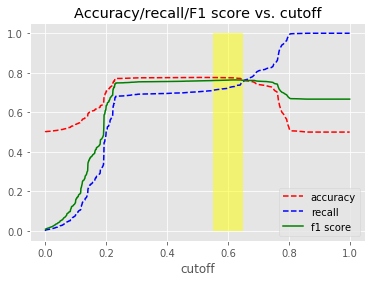

In [366]:
plt.plot(thresholds, accuracy_ls_2,'r--', label='accuracy')
plt.plot(thresholds, recall_ls_2, 'b--', label='recall')
plt.plot(thresholds, f1_ls_2, 'g',label='f1 score')

plt.plot(thresholds, np.array([1]*1000), color='white', alpha=0)
plt.fill_between(thresholds, np.array([1]*1000), where=(thresholds >0.55)&(thresholds<0.65), facecolor='yellow', alpha=0.5)

plt.xlabel('cutoff')
plt.title('Accuracy/recall/F1 score vs. cutoff')
plt.legend(loc=0)
plt.show()

In [407]:
print('Recall is 0.7553666989138021.\nAccuracy is 0.7634611381197879')

Recall is 0.7553666989138021.
Accuracy is 0.7634611381197879


In [454]:
logit_best = LogisticRegression(penalty='l1', C=1.0)
logit_best.fit(X_test,y_test)
y_pred_proba = logit_best.predict_proba(X_test)
y_pred_cutoff = np.where(y_pred_proba[:,0]<0.6,1,0)
confusion_matrix(y_test, y_pred_cutoff)

array([[30684,  4329],
       [ 2496,  4190]])

## parameter: weight

In [455]:
data_final = pd.read_csv('./data/data_final.csv', encoding='gb18030', index_col=0)

In [456]:
X = data_final.drop('OrderIn30', axis=1)
y = data_final['OrderIn30']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [457]:
standard_features = ['OwnedAmount', 'DeliveryFee', 'PointsPay', 'PointsEarned']
std = StandardScaler()
scaler = std.fit(X_train.loc[:,standard_features])
X_train.loc[:,standard_features] = scaler.transform(X_train.loc[:,standard_features])
X_test.loc[:,standard_features] = scaler.transform(X_test.loc[:,standard_features])

In [385]:
grid = {"C":np.logspace(-5,-1,7), 
        "penalty":["l1","l2"]
       }

logit = LogisticRegression(class_weight = 'balanced')
logit_cv=GridSearchCV(logit, grid, cv=10)
logit_cv.fit(X_train,y_train)

print("tuned hpyerparameters :(best parameters) ",logit_cv.best_params_)
print("accuracy :",logit_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1e-05, 'penalty': 'l1'}
accuracy : 0.8393048018418023


In [396]:
logit_best = LogisticRegression(penalty='l1', C=0.01, class_weight = 'balanced')
logit_best.fit(X_train,y_train) 

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [397]:
y_pred = logit_best.predict(X_train)
confusion_matrix(y_train, y_pred)

array([[69355, 12306],
       [ 4628, 11007]])

In [398]:
tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()
recall = tp/(tp + fn)
print(f'Recall is {recall}.')

Recall is 0.7039974416373521.


In [399]:
y_pred_proba = logit_best.predict_proba(X_train)
recall_ls_3 = []
accuracy_ls_3 = []
f1_ls_3 = []
thresholds = np.arange(0,1,0.001)

for thres in thresholds:
    y_pred = np.where(y_pred_proba[:,0]<thres,1,0)
    tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()
    recall = tp/(tp + fn)
    acc = (tp + tn)/(tp+tn+fp+fn)
    precision = tp/(tp + fp)
    f1 = 2*precision*recall/(precision+recall)
    
    
    recall_ls_3.append(recall)
    accuracy_ls_3.append(acc)
    f1_ls_3.append(f1)

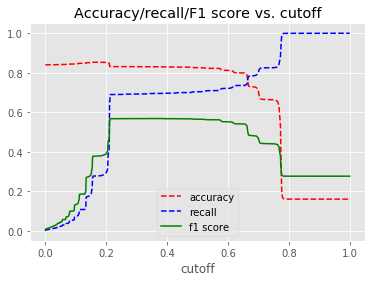

In [408]:
plt.plot(thresholds, accuracy_ls_3,'r--', label='accuracy')
plt.plot(thresholds, recall_ls_3, 'b--', label='recall')
plt.plot(thresholds, f1_ls_3, 'g',label='f1 score')

#plt.plot(thresholds, np.array([1]*1000), color='white', alpha=0)
#plt.fill_between(thresholds, np.array([1]*1000), where=(thresholds >0.55)&(thresholds<0.65), facecolor='yellow', alpha=0.5)

plt.xlabel('cutoff')
plt.title('Accuracy/recall/F1 score vs. cutoff')
plt.legend(loc=0)
plt.show()

In [458]:
logit_best = LogisticRegression(penalty='l1', C=0.01, class_weight = 'balanced')
logit_best.fit(X_test,y_test)
y_pred_proba = logit_best.predict_proba(X_test)
y_pred_cutoff = np.where(y_pred_proba[:,0]<0.6,1,0)
confusion_matrix(y_test, y_pred_cutoff)

array([[28918,  6095],
       [ 1773,  4913]])

In [459]:
result = pd.DataFrame({'Approach':['Original','Cutoff','Up-sampling','class_weight'],
                       'accuracy':[0.892, 0.829, 0.836, 0.811],
                       'recall':[0.281,0.707, 0.627,0.735]})

Text(0.5,1,'Best Recall with Different Approach')

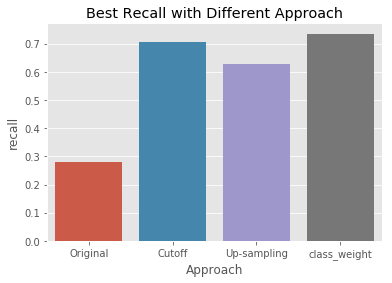

In [469]:
sns.barplot(x='Approach', y = 'recall', data=result)
plt.title('Best Recall with Different Approach')

Text(0.5,1,'Best Accuracy with Different Approach')

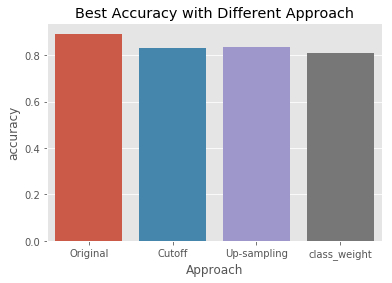

In [470]:
sns.barplot(x='Approach', y = 'accuracy', data=result)
plt.title('Best Accuracy with Different Approach')